In [24]:
from numsci.optimize import curve_fit, model_sig
import numpy as np
import matplotlib.pyplot as plt
from numba import cfunc, njit, types
import scipy

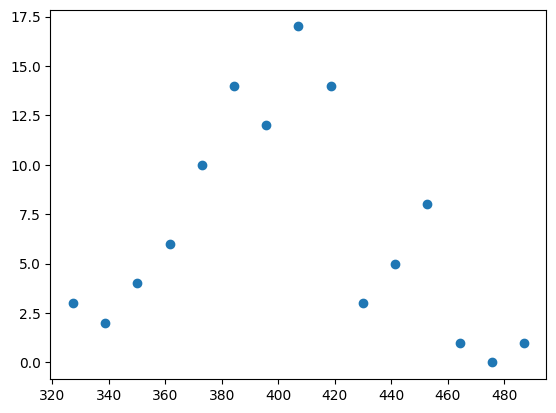

In [52]:
dist = np.random.normal(400, 30, 100)
counts, bins = np.histogram(dist, bins=15)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.scatter(bin_centers, counts)
plt.show()

In [53]:
@cfunc(model_sig, nopython=True)
def gaussian(x, params):
    A = params[0]
    mew = params[1]
    sig = params[2]
    return A*np.exp(-((x - mew)**2) / (2*(sig**2)))


# scipy_sig = types.double(types.double, types.double, types.double, types.double)
# @cfunc(scipy_sig, nopython=True)
@njit
def gaussian_scipy(x, A, mew, sig):
    return A*np.exp(-((x - mew)**2) / (2*(sig**2)))

In [54]:
import timeit

gaussian_addr = gaussian.address

@njit
def f1():
    popt, pcov = curve_fit(gaussian_addr, bin_centers, counts, p0=[200, 400, 10])
    return popt

def f2():
    popt, pcov = scipy.optimize.curve_fit(gaussian_scipy, bin_centers, counts, p0=[200, 400, 10])
    return popt

f1()
f2()
time_f1 = timeit.timeit(f1, number=1000)
time_f2 = timeit.timeit(f2, number=1000)

print(f"f1: {time_f1:.6f} seconds")
print(f"f2: {time_f2:.6f} seconds")


f1: 0.004621 seconds
f2: 0.311980 seconds
